本テーマでは日本原子力研究機構大洗研究所にある構造物強度確性試験装置(TTS)における配管内閉塞発生時の温度センサデータを解析対象として、深層学習で早期異常検知を行う。TTSとは高速炉の機器・配管等の構造物をモデル化した供試体に、実機よりはるかに厳しい熱過渡変化を負荷し、構造物の熱負荷に対する強度を明らかにすることを目的とした試験装置である。

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers

# 1. データセットの準備
ミニバッチ学習を行うために、TTSデータセットクラスを作成。

## (1) 正規化
ニューラルネットワークでの学習では入力値に重みを掛けていき、最終的に得られた出力値によって重みを更新していく必要がある。ここで、単位や特徴量の異なるデータを一緒に学習させると値の大きさによって特定の特徴量を持つデータの影響が大きくなったり、小さくなったりする。この現象を回避するために特徴量によって異なるデータスケールを統一する必要がある。すなわち、入力データが一定の範囲に収まるようにデータの最小値を0、最大値を1とする正規化を行う。

## (2) ローパスフィルタ
習データに含まれるノイズは学習の際に大きな負荷となり、学習のスムーズな進行を妨害し、最終的には適切な結果が得られないということになる。特に本研究で用いた構造物熱過渡試験施設(TTS)における実データには先で述べた図を見てもわかる通りノイズが多く含まれている。そこで本研究ではローパスフィルタ(Low-pass filter)をかけることでデータのノイズを軽減する。

## (3) データセットの拡張
本実験では、一度のNa閉塞の事例についてのデータを解析対象としており、解析データとしては多様性が低いという問題があった。特に異常データについて、真に異常特徴が出現している箇所は限定的であると考えられた。このようにデータ数が限られている場合、過学習やモデルの汎化性能の低下といった問題が起きうる。そこで、過学習を避けて、学習のロバストネスを高めるために元の学習データにランダム変動を付加することで疑似的に多様な学習データを作り出し、データ数を拡張した。ここで、ランダム変動量を$fluctuation$とし、それに基づき一様分布に従うランダムな数値を$rand$とすると、ノイズ付加後のデータセットは算出される。また、今回はデータセットを100倍に拡張した。
$$
x_{k}^{t}=(1-fluctuation+rand)\times x_{k}^{t}\\rand\in[0, 2\times fluctuation]
$$

In [20]:
class TtsAbnormalDataset(object):
  def __init__(self, data_dir, ses_files, start_idx, end_idx, abnormal_peaks, skips, channels, lpf, augumentation, fluctuation, batch_size):
    self.data_dir = data_dir
    self.ses_files = ses_files
    self.start_idx = start_idx
    self.end_idx = end_idx
    self.abnormal_peaks = abnormal_peaks
    self.skips = skips # データの間引き間隔(1以上)
    self.channels = channels # センサチャネル數
    self.lpf = lpf # Low pass 閾値
    self.augumentation = augumentation # データ拡張数
    self.fluctuation = fluctuation # ランダム変動量
    self.batch_size = batch_size

    # 測定データ読み取り
    self.skip_dataset, self.skip_dataset_ab = self.__get_ori_datasets()

    # 測定データ前処理
    self.processed_dataset = self.__low_pass_filter(self.__norm(self.skip_dataset))
    self.processed_dataset_ab = self.__low_pass_filter(self.__norm(self.skip_dataset_ab))

  def __iter__(self): 
    return self
 
  def __next__(self):  
    """学習用正常/異常データバッチ作成
    """

    pos_select_aug_batch = None
    neg_select_aug_batch = None
    count = 0
    while count < self.batch_size:
      time_steps = int(2000 / self.skips) 
      pos_aug_data = np.zeros((self.augumentation, time_steps, self.channels)) # 異常データセットの拡張
      neg_aug_data = np.zeros((self.augumentation, time_steps, self.channels)) # 正常データセットの拡張
      
      # データセットの拡張
      for i in range(self.augumentation):
        for j in range(time_steps):
          rand_neg = random.uniform(0, 2 * self.fluctuation) # 一様分布乱数
          rand_pos = random.uniform(0, 2 * self.fluctuation)
          neg_aug_data[i, j] = (1 - self.fluctuation + rand_neg) * self.processed_dataset_ab[random.randint(time_steps, 1000) - time_steps + j]
          pos_aug_data[i, j] = (1 - self.fluctuation + rand_pos) * self.processed_dataset_ab[random.randint(5600, 6299) - time_steps + j]
      
      pos_select_aug = random.randint(0, self.augumentation - 1)
      neg_select_aug = random.randint(0, self.augumentation - 1)

      if pos_select_aug_batch is None:
        pos_select_aug_batch = pos_aug_data[pos_select_aug].reshape(-1, time_steps, self.channels)
      else:
        pos_select_aug_batch = np.row_stack((pos_select_aug_batch, pos_aug_data[pos_select_aug].reshape(-1, time_steps, self.channels)))

      if neg_select_aug_batch is None:
        neg_select_aug_batch = neg_aug_data[neg_select_aug].reshape(-1, time_steps, self.channels)
      else:
        neg_select_aug_batch = np.row_stack((neg_select_aug_batch, neg_aug_data[neg_select_aug].reshape(-1, time_steps, self.channels)))
      
      count += 1

    sample = {'pos_data': pos_select_aug_batch, 
              'neg_data': neg_select_aug_batch}  
    return sample

  def __norm(self, data):
    """正規化
    """

    return (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

  def __low_pass_filter(self, data):
    """LPFでノイズ除去
    """

    results = None
    temp = np.zeros(data.shape[0])
    for i in range(data.shape[1]):
      temp = data[:, i]
      temp_f = np.fft.fft(temp) / (len(temp) / 2)
      temp_f[self.lpf:len(temp)] = 0
      temp_if = np.fft.ifft(temp_f) * (len(temp) / 2)
      if results is None:
        results = temp_if.reshape(-1, 1)
      else:
        results = np.hstack((results, temp_if.reshape(-1, 1)))
    
    return results

  def __get_ori_datasets(self):
    """測定データ読み取り
    """

    ori_dataset = None
    for ses_file in tqdm(self.ses_files, desc='Loading TTS files.'):
      ses_data = np.loadtxt(os.path.join(self.data_dir, ses_file), delimiter=',')
      if ori_dataset is None:
        ori_dataset = ses_data[self.start_idx:self.end_idx, 1].reshape(-1, 1)
      else:
        ori_dataset = np.hstack((ori_dataset, ses_data[self.start_idx:self.end_idx, 1].reshape(-1, 1)))

    ori_dataset_ab = np.vstack((ori_dataset[self.abnormal_peaks[0]:self.abnormal_peaks[1], :], 
                                ori_dataset[self.abnormal_peaks[2]:self.abnormal_peaks[3], :], 
                                ori_dataset[self.abnormal_peaks[3]:self.abnormal_peaks[4], :]))
    
    steps, steps_ab = len(ori_dataset), len(ori_dataset_ab)
    skip_dataset = None
    skip_dataset_ab = None
    for i in tqdm(range(int(steps/self.skips)), desc='Processing data.'):
      if skip_dataset is None:
        skip_dataset = ori_dataset[i*self.skips, :self.channels].reshape(-1, self.channels)
      else:
        skip_dataset = np.vstack((skip_dataset, ori_dataset[i*self.skips, :self.channels].reshape(-1, self.channels)))

    for i in tqdm(range(int(steps_ab/self.skips)), desc='Processing abnormal data.'):
      if skip_dataset_ab is None:
        skip_dataset_ab = ori_dataset_ab[i*self.skips, :self.channels].reshape(-1, self.channels)
      else:
        skip_dataset_ab = np.vstack((skip_dataset_ab, ori_dataset_ab[i*self.skips, :self.channels].reshape(-1, self.channels)))

    return skip_dataset, skip_dataset_ab

  def plot_data(self):
    plt.rcParams['figure.figsize'] = (20, 4.8)
    plt.rcParams['font.size'] = 18
    plt.subplot(xlabel='Time (sec)', ylabel='Temperature (degree)')
    plt.plot(self.skip_dataset)
    plt.show()

    plt.rcParams['figure.figsize'] = (20, 8)
    plt.rcParams['font.size'] = 18
    plt.subplot(xlabel='Time (sec)', ylabel='Temperature (degree)')
    plt.plot(self.skip_dataset_ab)
    plt.show()

    plt.rcParams['figure.figsize']=(20, 4.8)
    plt.rcParams['font.size'] = 18
    plt.subplot(xlabel='Time (*10 sec)', ylabel='Normalized Temperature (degree)')
    plt.plot(self.processed_dataset)
    plt.show()

    plt.rcParams['figure.figsize'] = (20, 4.8)
    plt.rcParams['font.size'] = 18
    plt.subplot(xlabel='Time (*10 sec)', ylabel='Normalized Temperature (degree)')
    plt.plot(self.processed_dataset_ab)
    plt.show()

  def get_data(self):
    return self.processed_dataset, self.processed_dataset_ab

  def get_test_batch(self, start_time):
    """テスト用バッチ作成
    """
    time_steps = int(2000 / self.skips) 
    sample = np.zeros((time_steps, self.channels))
    index = start_time - time_steps
    for i in range(time_steps):
      for j in range(self.channels):
        sample[i, j] = self.processed_dataset_ab[200 * index + i][j]
    
    print(sample.shape,sample.reshape(-1, time_steps, self.channels).shape)

    return sample.reshape(-1, time_steps, self.channels)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


測定データフォルダー

In [3]:
data_dir = 'drive/MyDrive/tts/data'

*   C1_2010_1_12-16.txt: 伝熱管出口Na温度C-1
*   C2_2010_1_12-16.txt: 伝熱管出口Na温度C-2
*   C3_2010_1_12-16.txt: 伝熱管出口Na温度C-3
*   C4_2010_1_12-16.txt: 伝熱管出口Na温度C-4
*   C5_2010_1_12-16.txt: 伝熱管出口Na温度C-5
*   C6_2010_1_12-16.txt: 伝熱管出口Na温度C-6
*   C7_2010_1_12-16.txt: 伝熱管出口Na温度C-7
*   C8_2010_1_12-16.txt: 伝熱管出口Na温度C-8
*   C9_2010_1_12-16.txt: 伝熱管出口Na温度C-9
*   C10_2010_1_12-16.txt: 伝熱管出口Na温度C-10
*   C11_2010_1_12-16.txt: 伝熱管出口Na温度C-11
*   C12_2010_1_12-16.txt: 伝熱管出口Na温度C-12
*   TI118_2010_1_12-16.txt: 冷却器入口Na温度TI-118
*   FI104_2010_1_12-16.txt: 低温側上流&下流&ミキシングNa流量FI-104
*   FI106_2010_1_12-16.txt: 低温側上流&下流&ミキシングNa流量FI-106
*   FI107_2010_1_12-16.txt: 低温側上流&下流&ミキシングNa流量FI-107

In [4]:
ses_files = ['C1_2009_11_12-14.txt', 'C2_2009_11_12-14.txt', 'C3_2009_11_12-14.txt', 'C4_2009_11_12-14.txt',
             'C5_2009_11_12-14.txt', 'C6_2009_11_12-14.txt', 'C7_2009_11_12-14.txt', 'C8_2009_11_12-14.txt',
             'C9_2009_11_12-14.txt', 'C10_2009_11_12-14.txt', 'C11_2009_11_12-14.txt', 'C12_2009_11_12-14.txt',
             'TI118_2009_11_12-14.txt', 'FI104_2009_11_12-14.txt', 'FI106_2009_11_12-14.txt', 'FI107_2009_11_12-14.txt']

引数の指定

In [5]:
start_idx = 0
end_idx = 150130
abnormal_peaks = [31400, 42600, 46200, 60600, 98000]
skips = 10
channels = 12
lpf = 100
augumentation = 100
fluctuation = 0.1
batch_size = 20

TtsAbnormalDatasetクラスのインスタンスを作成。関連引数を渡します。

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(15013, 12) (6300, 12)


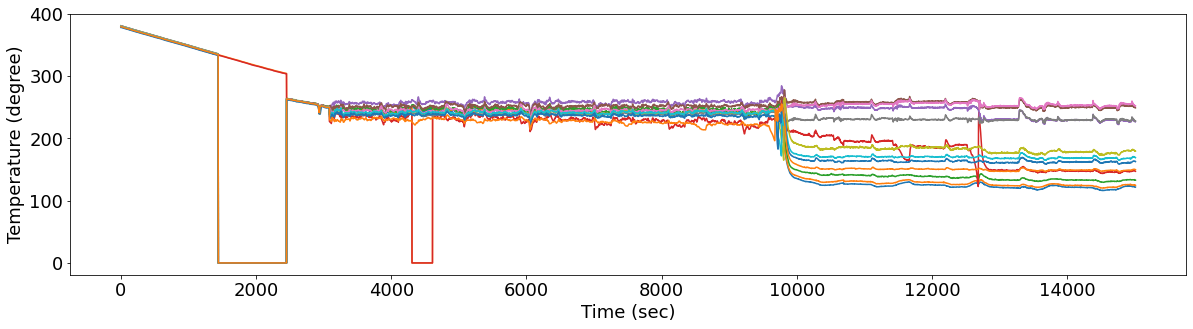

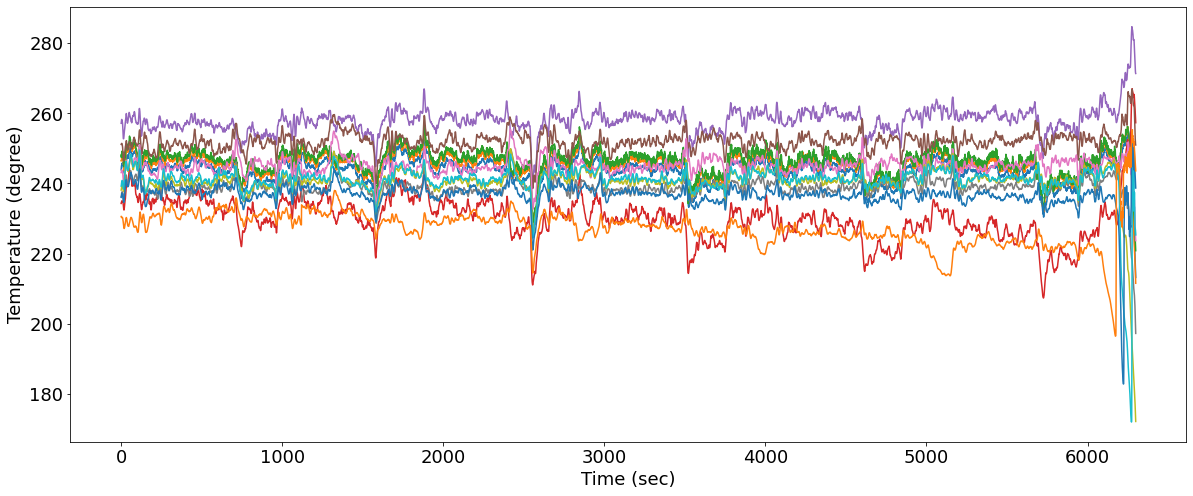

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


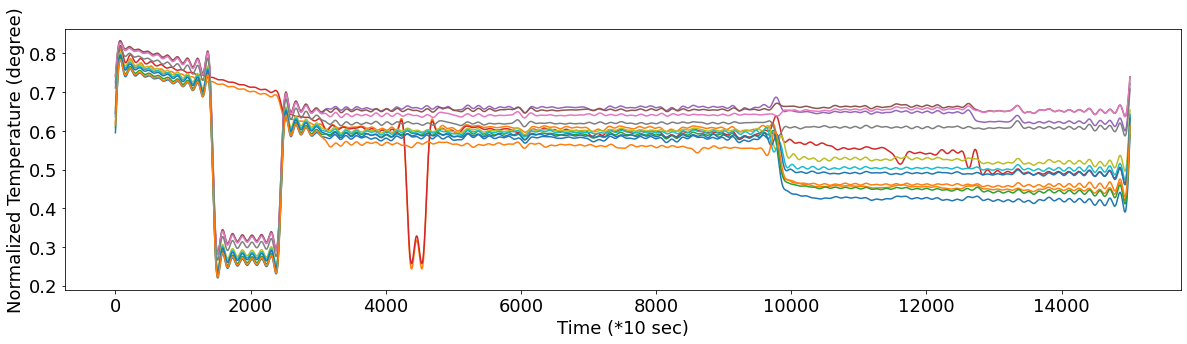

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


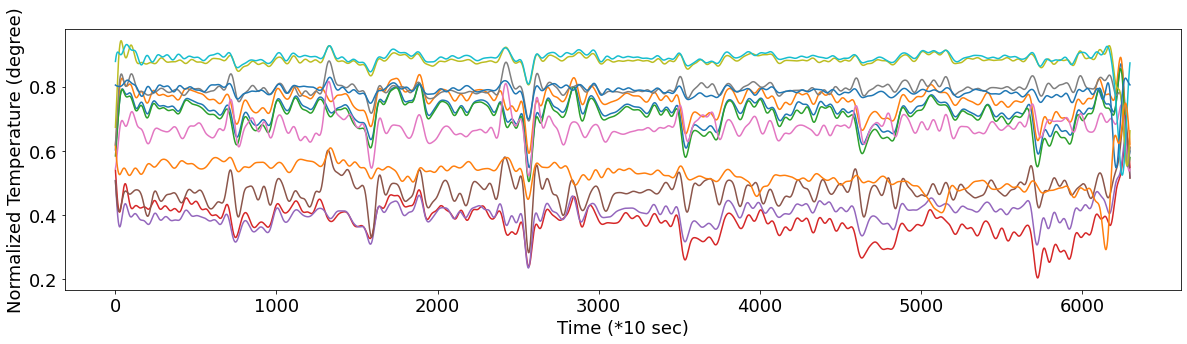

In [22]:
tts_dataset = TtsAbnormalDataset(data_dir=data_dir,
                                 ses_files=ses_files,
                                 start_idx=start_idx,
                                 end_idx=end_idx,
                                 abnormal_peaks=abnormal_peaks,
                                 skips=skips,
                                 channels=channels,
                                 lpf=lpf,
                                 augumentation=augumentation,
                                 fluctuation=fluctuation,
                                 batch_size=batch_size)
tts_dataset.plot_data()

図においてセンサ値は12色で色分けされているが、これは出口温度センサが12チャンネル有していることに起因する。本実験では12チャンネル全てを入力データとしてモデルに入力する。このデータにおいて、時間t=31400-98000秒では出口Na温度は250℃付近である程度均一になっており、t=98000秒以降では出口Na温度は散逸的になっている。本実験では、t=98000秒以降のように異常が顕著となる前に異常兆候を早期に検知することが目的であるため、t=31400-98000秒のセンサデータを解析対象とする。しかしながら、t=42600-46200秒においてデータ欠損が生じていたため、実際の解析対象はt=31400-42600秒とt=46200-98000秒をつなぎ合わせた、合計63000秒とした。

# 2. モデルの構築
`tf.keras.Model`を継承したサブクラスを定義する。
`__init__()`で使用するモジュール（レイヤー）のインスタンスを生成し、`call()`で所望の順番で適用していく。

In [ ]:
class TtsModel(tf.keras.Model):
    def __init__(self):
        he_initializer = tf.keras.initializers.he_normal()
        norm_initializer = tf.keras.initializers.RandomNormal(mean=1.0, stddev=0.01)
        super(TtsModel, self).__init__()
        self.conv1d1 = layers.Conv1D(128, kernel_size=(9,), kernel_initializer=he_initializer, padding='same', activation='relu', input_shape=(40,200,12))
        self.norm1 = layers.BatchNormalization(momentum=0.90, epsilon=10**-5, gamma_initializer=norm_initializer)
        self.conv1d2 = layers.Conv1D(128, kernel_size=(9,), kernel_initializer=he_initializer, padding='same', activation='relu')
        self.norm2 = layers.BatchNormalization(momentum=0.90, epsilon=10**-5, gamma_initializer=norm_initializer)
        self.conv1d3 = layers.Conv1D(1, kernel_size=(1,), kernel_initializer=he_initializer, activation='sigmoid')
        self.pooling = layers.AveragePooling1D(pool_size=10)

    def call(self, x):
        x = self.conv1d1(x)
        x = self.norm1(x)
        x = self.conv1d2(x)
        x = self.norm2(x)
        x = self.conv1d3(x)
        x = self.pooling(x)
        return x

***Transformer:***
1. Attention Machanism:
  Self-Attention --> Multihead Attention

data: skip_dataset:(151300,12), skip_dataset_ab:(6300,12)


In [ ]:
#transformaer
def self_attention(q,k,v,mask,d_model):

    qk = tf.matmul(q,k,transpose_b = True)
    scaled_qk = tf.divide(qk,math.sqrt(tf.cast(d_model,tf.float32)))

    if mask is not None:
        scaled_qk += (mask*-1e9)# mask步骤，用 -1e9 代表负无穷--padding mask 使得用于增长的0部分 在最终输出中不占位置 padding mask
        
    attention_weights = tf.nn.softmax(scaled_qk,axis = -1)
    final_output = tf.matmul(attention_weights,v)
  
    return attention_weights,final_output

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,num_heads,d_model):
        super(MultiHeadAttention,self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert self.d_model % self.num_heads ==0 

        self.depth = self.d_model//self.num_heads

        self.wq = tf.keras.layers.Dense(units = d_model)
        self.wk = tf.keras.layers.Dense(units = d_model)
        self.wv = tf.keras.layers.Dense(units = d_model)
        self.dense1 = tf.keras.layers.Dense(units = d_model)

#x--input series divide into heads part, add the dimension of the turn of the head
    def split_into_heads(self,x,batch_size):
        #print("x shape is",x.get_shape())
        x = tf.reshape(x,(batch_size,-1,self.num_heads,self.depth))
        return tf.transpose(x,perm = [0,2,1,3])
    
    def call(self,q,k,v,mask):
        batch_size = tf.shape(q)[0]
        print(tf.shape(q))
        
        #linear layer 
        q = self.wq(q)
        k = self.wk(k)
        v = self.wq(v)
        
        #splitting into heads
        q = self.split_into_heads(q,batch_size)
        k = self.split_into_heads(k,batch_size)
        v = self.split_into_heads(v,batch_size)

        attention_weights,multi_head_output = self_attention(q,k,v,mask,self.depth) #for every head

        pre_concat_multi_head_output =  tf.transpose(multi_head_output,perm = [0,2,1,3])
        post_concat_multi_head_output =  tf.reshape(pre_concat_multi_head_output,(batch_size,-1,self.d_model))
        
        final_output = self.dense1(post_concat_multi_head_output)

        return attention_weights,final_output

2 Masking:

In [ ]:
# Masking 

#1 - input padding masking : Lower triangular part hidden mask
def generate_mask(seq):
    seq  = tf.cast(math.equal(seq,0),tf.float32)
    return seq[:,tf.newaxis,tf.newaxis,:]
#from other repo mask https://github.com/bryanlimy/tf2-transformer-chatbot/blob/master/transformer/model.py  
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), dtype=tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]

#2 mask the sequence behind the predicting sequence 
def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size,size)),-1,0)
    return mask
    
#from other repo mask 
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(
      tf.ones((seq_len, seq_len), dtype=tf.float32), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

3. Positional encoding

In [ ]:
#embedding --similarity, without the positional distance information. Thus add the position on embeddings
class get_positional_encoding(tf.keras.layers.Layer):
  def __init__(self,position,d_model):
    super(get_positional_encoding,self).__init__()
    self.pos_encoding = self.positional_encoding(position,d_model)
  
  def get_angle(self,position,i,d_model):
    angle = 1 / tf.pow(10000, (2*(i//2))/ tf.cast(d_model,tf.float32))
    return position*angle

  def positional_encoding(position,d_model): #d_model = 512 if 128
    angle_final = get_angle(tf.expand_dims(tf.range(tf.cast(position,tf.float32)),axis = 1),tf.expand_dims(tf.range(tf.cast(d_model,tf.float32)),axis = 0),d_model)
    np_angle_final = angle_final.numpy()
    np_angle_final[:,0::2] = np.sin(np_angle_final[:,0::2])
    np_angle_final[:,1::2] = np.cos(np_angle_final[:,1::2])
    angle_final = tf.convert_to_tensor(np_angle_final)
    pos_encoding = angle_final[tf.newaxis,...]
    return tf.cast(pos_encoding,dtype=tf.float32)
  
  def call(self,input):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], : ]

4. Encoding and decoding layer:

In [ ]:
def FeedForward_Net(d_model,hidden_layer_shape): #hidden_layer_shape--units
    return tf.keras.Sequential([
      tf.keras.layers.Dense(hidden_layer_shape, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model) normalization done on the final d_model axis
  ])

In [ ]:
class Encoding_Layer(tf.keras.layers.Layer):
    def __init__(self,num_heads,d_model,hidden_layer_shape,rate=0.1):
        super(Encoding_Layer,self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.multi_head_attention = MultiHeadAttention(num_heads,d_model)
        self.ffd_net = FeedForward_Net(d_model,hidden_layer_shape)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self,x,mask,training = True):
        #part 1
        _,multihead_output = self.multi_head_attention(x,x,x,mask)
        dropout_multihead_output = self.dropout1(multihead_output,training = training)
        skip_dropout_output = tf.add(x,dropout_multihead_output)
        norm1_skip_output  = self.norm1(skip_dropout_output)        
        #part 2
        point_norm1_output = self.ffd_net(norm1_skip_output)
        dropout_point_output = self.dropout2(point_norm1_output,training = training)
        skip_dropout_output = tf.add(dropout_point_output,norm1_skip_output)
        norm2_skip_output = self.norm2(skip_dropout_output)
        return norm2_skip_output

In [ ]:
class Decoding_Layer(tf.keras.layers.Layer):
    def __init__(self,num_heads,d_model,hidden_layer_shape,rate = 0.1):
        super(Decoding_Layer,self).__init__()
        self.multi_head_attention1 = MultiHeadAttention(num_heads,d_model,)
        self.multi_head_attention2 = MultiHeadAttention(num_heads,d_model)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.point_ffd_net = FeedForward_Net(d_model,hidden_layer_shape)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self,x,k,v,la_mask,pd_mask,training = False):
        #decoder attention with look ahead mask(include padding mask)
        _,multihead1_output = self.multi_head_attention1(x,x,x,la_mask)
        dropout1_multihead1_output = self.dropout1(multihead1_output)
        skip1_dropout1_output = tf.add(dropout1_multihead1_output,x)
        norm1_skip1_output = self.norm1(skip1_dropout1_output)

        #decoder&encoder attention with padding mask
        _,multihead2_output  = self.multi_head_attention2(x,k,v,pd_mask)
        dropout2_multihead2_output = self.dropout2(multihead2_output)
        skip2_dropout2_output = tf.add(dropout2_multihead2_output,norm1_skip1_output)
        norm2_skip2_output = self.norm2(skip2_dropout2_output)

        #sum and normalize
        point_norm2_output = self.point_ffd_net(norm2_skip2_output)
        dropout3_point_output = self.dropout3(point_norm2_output)
        skip3_dropout3_output = tf.add(norm2_skip2_output,dropout3_point_output)
        norm3_skip3_output = self.norm3(skip3_dropout3_output)
        return norm3_skip3_output

5 Encoder and Decoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,hidden_layer_shape,input_size, max_pos_encoding,num_enc_layers,rate = 0.1):
        super(Encoder,self).__init__()
        self.position_encoding = get_positional_encoding(max_pos_encoding,d_model)
        self.input_embedding = tf.keras.layers.Embedding(input_size,tf.cast(d_model,tf.int32))
        self.encoder_layers = [Encoding_Layer(num_heads,d_model,hidden_layer_shape,rate) for _ in range(num_enc_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.d_model = d_model
        self.num_enc_layers = num_enc_layers

    def call(self,x,mask,training):
        seq_len = x.get_shape()[1]
#        print(seq_len)
        
        embedding = self.input_embedding(x)
        scaled_embedding = math.multiply(embedding,math.sqrt(tf.cast(self.d_model,tf.float32)))
        pos_scaled_embedding = math.add(scaled_embedding,self.position_encoding[:,:seq_len,:])
        
        output_input_encoder = self.dropout(pos_scaled_embedding,training = training)

        for i in range(self.num_enc_layers):
            output_input_encoder = self.encoder_layers[i](output_input_encoder,mask,False)
        return output_input_encoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,num_heads,d_model,hidden_layer_shape,max_position_encoding,num_layers,dec_input_size,rate=0.1): #dec_input_size = decoder input size
        super(Decoder,self).__init__()
        self.position_encoding = get_positional_encoding(max_position_encoding,d_model)
        self.d_model = d_model
        self.num_layers = num_layers
        self.input_embedding = tf.keras.layers.Embedding(dec_input_size,,d_model)
        self.decoder_layers = [Decoding_Layer(num_heads,d_model,hidden_layer_shape) for _ in tf.range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.num_layers = num_layers

    def call(self,x,encoder_output,look_ahead_mask,padding_mask,training = True):
        seq_len = tf.shape(x)[1]
        embedding = self.input_embedding(x)
        scaled_embedding = math.multiply(embedding,math.sqrt(tf.cast(self.d_model,tf.float32)))
        positional_encoding = self.position_encoding[:,:seq_len,:]
        pos_scaled_embedding = tf.add(scaled_embedding,positional_encoding)
        
        output_input_decoder = self.dropout(pos_scaled_embedding,training = training)
        for i in range(self.num_layers):
            output_input_decoder = self.decoder_layers[i](output_input_decoder,encoder_output,encoder_output,look_ahead_mask,padding_mask)
        
        return output_input_decoder

6. Transformer

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,num_layers,num_heads,d_model,hidden_layer_shape,dec_input_size, pe_input,pe_target,input_vocab_size,rate = 0.1):
        super(Transformer,self).__init__()
        self.encoder = Encoder(d_model,num_heads,hidden_layer_shape,input_size,pe_input,num_layers,rate) #pe_input--max_pos_encoding
        self.decoder = Decoder(num_heads,d_model,hidden_layer_shape,pe_target,num_layers,dec_input_size,rate) #pe_output--max_pos_encoding dec_input_Size--detect input size
        self.final_layer = tf.keras.layers.Dense(dec_input_size)

    def call(self,input,target,enc_padding_mask,look_ahead_mask,dec_padding_mask,training = False):
        enc_output = self.encoder(input,enc_padding_mask,training)
        dec_output = self.decoder(target,enc_output,look_ahead_mask,dec_padding_mask,training)
        final_output = self.final_layer(dec_output)

        return final_output


7. parameters settings for whole model

In [ ]:
num_layers = 6
num_heads = 8
d_model = 512
hidden_layer_shape = 512
dec_input_size =  
pe_input = len(input[1]) #maximum position--length of the encoder input
pe_target = #maximum position--length of the decoder input
iuput_vocab_size = #maximum position--length of the encoder input
skips = 10
channels = 12
lpf = 100
augumentation = 100
fluctuation = 0.1
batch_size = 20

model = Transformer()
model.build(input_shape=(200,12))

# モデルの内容を出力
model.summary()

# 最適化関数の定義
#optimizer = tf.keras.optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.8, nesterov=True)--loss  前段不降后段降
optimizer = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-4, momentum=0.8, nesterov=True)

#optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

LSTM

In [ ]:
#LSTM モデル
class TtsModel(tf.keras.Model):
    def __init__(self):
        he_initializer = tf.keras.initializers.he_normal()
        norm_initializer = tf.keras.initializers.RandomNormal(mean=1.0, stddev=0.01)
        super(TtsModel, self).__init__()
        self.lstm1 = layers.LSTM(units=128, activation='relu', return_sequences=True, input_shape=(200,12), kernel_initializer=he_initializer)
        self.norm1 = layers.BatchNormalization(momentum=0.90, epsilon=10**-5, gamma_initializer=norm_initializer)
        self.lstm2 = layers.LSTM(units=128, activation='relu', return_sequences=True,kernel_initializer=he_initializer)
        self.norm2 = layers.BatchNormalization(momentum=0.90, epsilon=10**-5, gamma_initializer=norm_initializer)
        self.lstm3 = layers.LSTM(units=1, activation='sigmoid', return_sequences=True,kernel_initializer=he_initializer)
        self.pooling = layers.AveragePooling1D(pool_size=10)


    def call(self, x):

        x = self.lstm1(x)
        x = self.norm1(x)
        x = self.lstm2(x)
        x = self.norm2(x)
        x = self.lstm3(x)
        x = self.pooling(x)
        return x


モデルの生成と最適化関数の定義。勾配降下法の最適化アルゴリズムの一つであるAdam(Adaptive Moment Estimation)法を使用する。

In [ ]:
# モデルの生成
model = TtsModel()
model.build(input_shape=(40,200,12))

# モデルの内容を出力
model.summary()

# 最適化関数の定義
#optimizer = tf.keras.optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.8, nesterov=True)--loss  前段不降后段降
optimizer = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-4, momentum=0.8, nesterov=True)

#optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

Model: "tts_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  72192     
_________________________________________________________________
batch_normalization (BatchNo multiple                  512       
_________________________________________________________________
lstm_1 (LSTM)                multiple                  131584    
_________________________________________________________________
batch_normalization_1 (Batch multiple                  512       
_________________________________________________________________
lstm_2 (LSTM)                multiple                  520       
_________________________________________________________________
average_pooling1d (AveragePo multiple                  0         
Total params: 205,320
Trainable params: 204,808
Non-trainable params: 512
_________________________________________________

# 3. モデルの学習

損失関数：$L=max(0, 1-\max_{i\in B_{a}}y_{pos}^{t}+\max_{i\in B_{n}}y_{neg}^{t})+\lambda$

正則化項：$\lambda=\lambda_{smooth}+\lambda_{sparse}=\mu_{1}\sum_{i=1}^{n-1}{(f(v_a^i)-f(v_a^{i+1}))}^{2}+\mu_{2}\sum_{i=1}^{n}f(v_a^i)$

In [11]:
max_step = 500 # 学習の繰り返し回数
m1 = 0.001 #正規化項内の定数
m2 = 0.001
loss_value =[]

process = tqdm(enumerate(tts_dataset), total=max_step)
for step, data in process:
  if step == max_step:
    break
  pos_data, neg_data = data['pos_data'], data['neg_data']
  batch = tf.concat([pos_data, neg_data],0)
  #[40,200,12]のbatchが出来上がる

  loss = 0.0 #stepごとにlossを初期化
  with tf.GradientTape() as t:
      sum1 = 0.0
      sum2 = 0.0 
      result = tf.zeros([40, 0, 1])
      #result[0]からresult[19]が異常データに対する推定値, result[20]からresult[39]が正常データに対する推定値になっている
      for i in range(0, 200, 10):
          buf = model(batch[:, i:i+10])
          result = tf.concat([result, buf], axis=1)

      l_sum = []
      for i in range(20):
          y_pos_max = tf.math.reduce_max(result[i])
          y_neg_max = tf.math.reduce_max(result[i+20])
          l = tf.math.reduce_max([0, tf.math.add(1, tf.math.subtract(y_neg_max, y_pos_max))]) #波形1セット分の損失
          l_sum.append(l)

      loss = tf.math.reduce_sum(l_sum)
      
      #正規化項を計算
      pos_result = np.squeeze(result[0:20], axis=2).flatten()
      number = []
      for k in range(399):
          number.append(tf.square(tf.math.subtract(pos_result[k], pos_result[k+1])))
      sum1 = tf.math.reduce_sum(number)
      sum2 = tf.math.reduce_sum(pos_result)
      smooth = tf.math.scalar_mul(m1, sum1)
      sparse = tf.math.scalar_mul(m2, sum2)
      lasso = tf.math.add(smooth, sparse)
      loss = tf.math.add(loss, lasso)
      loss_value.append(loss)
  d = t.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(d, model.trainable_weights))
  print(loss_value[-1])
  postfix = 'Step: {0:4d}, Loss: {1:.3f}'.format(step+1, loss)
  process.set_postfix_str(postfix)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


KeyboardInterrupt: ignored

In [ ]:
  plt.rcParams['figure.figsize'] = (20, 4.8)
  plt.rcParams['font.size'] = 18
  plt.subplot(xlabel='Time (step)', ylabel='Train Loss')
  plt.plot(range(len(loss_value)),loss_value,'r+')
  plt.show()

# 4. 学習済みモデルの評価

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


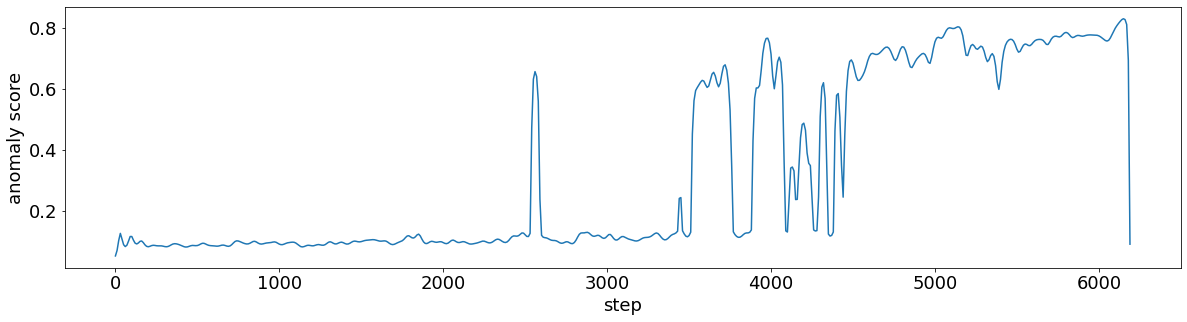

In [ ]:
test_batch = np.zeros([40, 200, 12])
for step in tqdm(range(200, 231), desc='Generating testing data.'):  
    batch_t = tts_dataset.get_test_batch(step)
    test_batch[step - 200] = batch_t

test_result = tf.zeros([40, 0, 1])
for i in tqdm(range(0, 200, 10), desc='Evaluating.'):
    test_buf = model(test_batch[:, i:i+10])
    test_result = tf.concat([test_result, test_buf], axis=1)
test_result = test_result[0:31]
test_result = np.squeeze(test_result, axis=2).flatten()

plt.rcParams['font.size'] = 18
plt.subplot(xlabel='step', ylabel='anomaly score')
plt.plot(np.arange(0, 6200, 10), test_result)
plt.show()